In [1]:
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/lib/python3.10/dist-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The

In [35]:
tokenizer = T5Tokenizer.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained("t5-small", output_attentions=True)

input_text = "translate English to French: Hi"
inputs = tokenizer(input_text, return_tensors="pt")

input_text2 = "Fuck off"
inputs2 = tokenizer(input_text2, return_tensors="pt")

outputs = model(input_ids=inputs.input_ids, decoder_input_ids=inputs2.input_ids)
encoder_attentions = outputs.encoder_attentions  # Attention from encoder layers
decoder_attentions = outputs.decoder_attentions  # Attention from decoder self-attention
cross_attentions = outputs.cross_attentions      # Attention from decoder cross-attention

In [29]:
inputs

{'input_ids': tensor([[2018,    1]]), 'attention_mask': tensor([[1, 1]])}

In [36]:
encoder_attentions[0].shape

torch.Size([1, 8, 7, 7])

In [37]:
decoder_attentions[0].shape

torch.Size([1, 8, 4, 4])

In [42]:
cross_attentions[0].shape

torch.Size([1, 8, 4, 7])

In [47]:
outputs = model.generate(input_ids=inputs.input_ids)
# cross_attentions = outputs.cross_attentions
# cross_attentions[0].shape

In [48]:
outputs

tensor([[ 0,  3, 18,  3, 18,  3, 18,  3, 18,  3, 18,  3, 18,  3, 18,  3, 18,  3,
         18,  3, 18]])

In [7]:
collected_attentions = {}

def hook_fn(module, input, output):
    attn_weights = output[-1] if isinstance(output, tuple) else output
    collected_attentions[module] = attn_weights.detach().cpu()

model = T5ForConditionalGeneration.from_pretrained("t5-small")
tokenizer = T5Tokenizer.from_pretrained("t5-small")

hooks = []
for name, module in model.named_modules():
    if module.__class__.__name__ == "T5Attention":
        hooks.append(module.register_forward_hook(hook_fn))

# forward
input_text = "translate English to French: The house is wonderful."
inputs = tokenizer(input_text, return_tensors="pt")
model(input_ids=inputs.input_ids, decoder_input_ids=inputs.input_ids)

# Remove hooks if no longer needed
for h in hooks:
    h.remove()

In [8]:
collected_attentions

{T5Attention(
   (q): Linear(in_features=512, out_features=512, bias=False)
   (k): Linear(in_features=512, out_features=512, bias=False)
   (v): Linear(in_features=512, out_features=512, bias=False)
   (o): Linear(in_features=512, out_features=512, bias=False)
   (relative_attention_bias): Embedding(32, 8)
 ): tensor([[[[ -2.5156,  -5.0000,  -4.7500,  -4.6875,  -4.7188,  -4.7500,  -4.8750,
             -4.8750,  -4.9062,  -4.9062,  -4.9062],
           [  5.4375,  -2.5156,  -5.0000,  -4.7500,  -4.6875,  -4.7188,  -4.7500,
             -4.8750,  -4.8750,  -4.9062,  -4.9062],
           [  4.1250,   5.4375,  -2.5156,  -5.0000,  -4.7500,  -4.6875,  -4.7188,
             -4.7500,  -4.8750,  -4.8750,  -4.9062],
           [  3.2656,   4.1250,   5.4375,  -2.5156,  -5.0000,  -4.7500,  -4.6875,
             -4.7188,  -4.7500,  -4.8750,  -4.8750],
           [  2.5938,   3.2656,   4.1250,   5.4375,  -2.5156,  -5.0000,  -4.7500,
             -4.6875,  -4.7188,  -4.7500,  -4.8750],
           [ 

# Encoder
## Visualize heads in layer

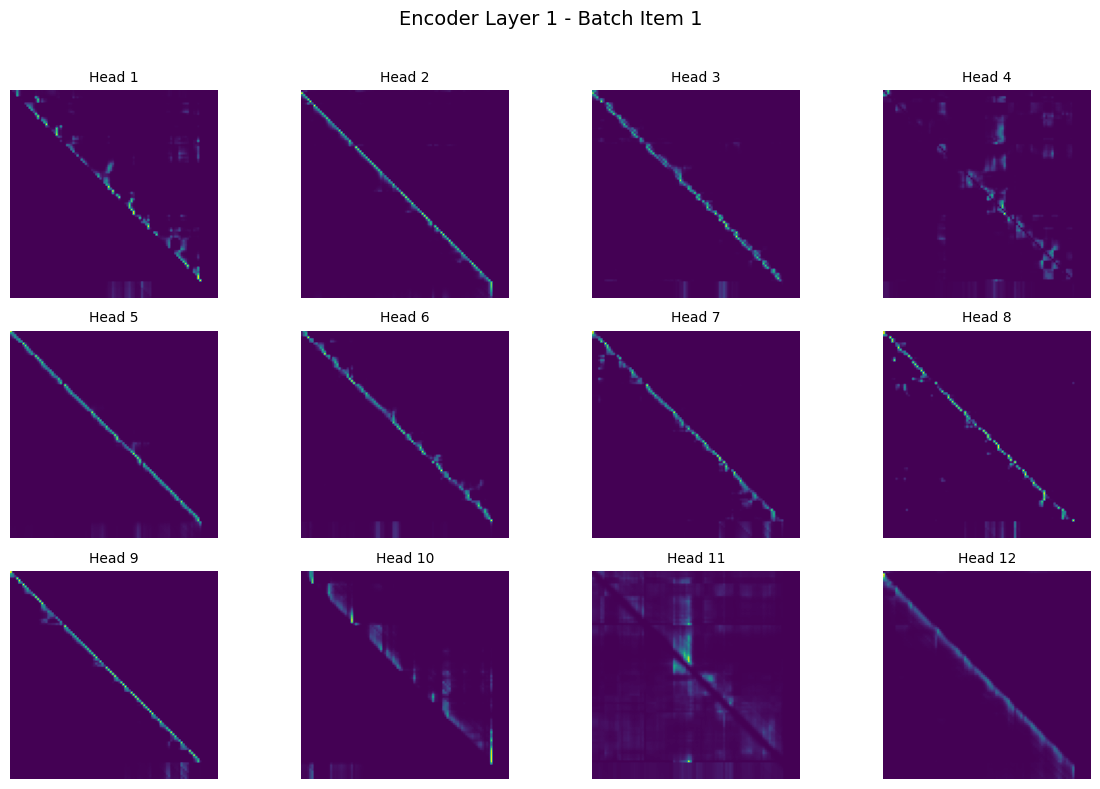

In [12]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

# Change to your working directory if needed
os.chdir('/auto/brno2/home/javorek/T5_for_SLT/')

# Define parameters for selecting the JSON file and indices
batch_file = 'batch_0.json'   # JSON filename in results/attention_batches_simple/
layer_index = 0               # Index of the encoder layer (0-indexed)
batch_index = 0               # Index of the batch item (0-indexed)

# Toggle to show only the top-left 100×100 region of each matrix
crop_attention = True
crop_size = 100

# Construct the full path to the JSON file
json_file_path = os.path.join(
    '/auto/brno2/home/javorek/T5_for_SLT/',
    'results', 
    'attention_batches_simple', 
    batch_file
)

# Load the JSON file containing the saved attention data
with open(json_file_path, 'r') as f:
    data = json.load(f)

# Retrieve the encoder attentions from the data
encoder_attentions = data['encoder_attentions']

# Number of heads in this layer/batch (usually 12 for T5-base, can vary for other models)
num_heads = len(encoder_attentions[layer_index][batch_index])

# Create a 3×4 grid for plotting 12 heads
rows, cols = 3, 4
fig, axes = plt.subplots(rows, cols, figsize=(12, 8))
axes = axes.flatten()

# Add a main title indicating which layer and batch item we are visualizing
fig.suptitle(f'Encoder Layer {layer_index+1} - Batch Item {batch_index+1}', fontsize=14)

for head in range(num_heads):
    # Convert each head's attention matrix to a NumPy array
    attn_matrix = np.array(encoder_attentions[layer_index][batch_index][head])
    
    # Optionally crop the attention matrix to 100×100
    if crop_attention:
        attn_matrix = attn_matrix[:crop_size, :crop_size]
    
    # Plot the attention matrix
    axes[head].imshow(attn_matrix, cmap='viridis')
    axes[head].set_title(f'Head {head+1}', fontsize=10)
    axes[head].axis('off')

# Remove any unused subplots if num_heads < rows*cols
for ax in axes[num_heads:]:
    ax.remove()

# Tighten layout to reduce empty space
plt.tight_layout()

# Adjust top to accommodate the suptitle
plt.subplots_adjust(top=0.88)

plt.show()

## Visualize heads in layer and save 

In [3]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

# Define the path to the folder with JSON files
folder_path = '/auto/brno2/home/javorek/T5_for_SLT/results/attention_batches_simple/'

# Toggle to show only the top-left 100×100 region of each matrix
crop_attention = True
crop_size = 100

# Create a subfolder for saving plots
plot_folder = os.path.join(folder_path, "plots")
os.makedirs(plot_folder, exist_ok=True)

# Grid dimensions: 3 rows, 4 columns for 12 heads
rows, cols = 3, 4

# Get a sorted list of JSON files and process only the first 10
json_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.json')])

for filename in json_files:
    json_file_path = os.path.join(folder_path, filename)

    # Load the JSON file containing the saved attention data
    with open(json_file_path, 'r') as f:
        data = json.load(f)

    # Retrieve encoder attentions
    encoder_attentions = data['encoder_attentions']
    num_layers = len(encoder_attentions)
    
    # Batch size is 1, so always use batch_index 0
    batch_index = 0

    # Loop through each encoder layer in this file
    for layer_index in range(num_layers):
        # Create a figure with a 3×4 grid of subplots
        fig, axes = plt.subplots(rows, cols, figsize=(12, 8))
        axes = axes.flatten()

        # Main title indicating the file and layer being visualized
        fig.suptitle(
            f"File: {filename}\nEncoder Layer {layer_index+1} - Batch Item {batch_index+1}",
            fontsize=14
        )

        # Number of heads for this layer
        num_heads = len(encoder_attentions[layer_index][batch_index])

        # Plot each head
        for head in range(num_heads):
            if head >= rows * cols:
                # Only plot up to 12 heads if there are more
                break

            # Convert the attention matrix to a NumPy array
            attn_matrix = np.array(encoder_attentions[layer_index][batch_index][head])
            
            # Optionally crop the attention matrix to 100×100
            if crop_attention:
                attn_matrix = attn_matrix[:crop_size, :crop_size]

            # Plot the matrix
            axes[head].imshow(attn_matrix, cmap='viridis')
            axes[head].set_title(f"Head {head+1}", fontsize=10)
            axes[head].axis('off')

        # Remove any unused subplots if there are fewer than rows*cols heads
        for ax in axes[num_heads:]:
            ax.remove()

        # Tight layout to reduce extra spacing
        plt.tight_layout()
        # Adjust top margin to accommodate the main title
        plt.subplots_adjust(top=0.80)

        # Construct output filename and save the figure
        out_filename = f"{os.path.splitext(filename)[0]}_layer{layer_index+1}.png"
        out_filepath = os.path.join(plot_folder, out_filename)
        plt.savefig(out_filepath, dpi=150)
        plt.close(fig)

        print(f"Saved: {out_filepath}")

Saved: /auto/brno2/home/javorek/T5_for_SLT/results/attention_batches_simple/plots/batch_0_layer1.png
Saved: /auto/brno2/home/javorek/T5_for_SLT/results/attention_batches_simple/plots/batch_0_layer2.png
Saved: /auto/brno2/home/javorek/T5_for_SLT/results/attention_batches_simple/plots/batch_0_layer3.png
Saved: /auto/brno2/home/javorek/T5_for_SLT/results/attention_batches_simple/plots/batch_0_layer4.png
Saved: /auto/brno2/home/javorek/T5_for_SLT/results/attention_batches_simple/plots/batch_0_layer5.png
Saved: /auto/brno2/home/javorek/T5_for_SLT/results/attention_batches_simple/plots/batch_0_layer6.png
Saved: /auto/brno2/home/javorek/T5_for_SLT/results/attention_batches_simple/plots/batch_0_layer7.png
Saved: /auto/brno2/home/javorek/T5_for_SLT/results/attention_batches_simple/plots/batch_0_layer8.png
Saved: /auto/brno2/home/javorek/T5_for_SLT/results/attention_batches_simple/plots/batch_0_layer9.png
Saved: /auto/brno2/home/javorek/T5_for_SLT/results/attention_batches_simple/plots/batch_0_l

JSONDecodeError: Expecting ',' delimiter: line 1 column 128124482 (char 128124481)

## Average of each head through layers

In [2]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

# Path to the folder with JSON files
folder_path = '/auto/brno2/home/javorek/T5_for_SLT/results/attention_batches_simple/'

# Create a subfolder for saving average plots
avg_plot_folder = os.path.join(folder_path, "average_plots_auto_crop_square")
os.makedirs(avg_plot_folder, exist_ok=True)

# Threshold for deciding if a row/column is "non-zero" (helps with floating precision)
NONZERO_THRESHOLD = 1e-9

def find_global_bounding_box(matrices, threshold=NONZERO_THRESHOLD):
    """
    Given a list of 2D NumPy arrays (all from the same head across different layers),
    find the minimal bounding box that contains all values above 'threshold'.
    
    Returns (min_row, max_row, min_col, max_col).
    If all values are effectively zero, returns None.
    """
    nonempty_rows_all = []
    nonempty_cols_all = []

    # Collect non-empty row/col indices across all matrices
    for mat in matrices:
        row_sums = np.sum(mat, axis=1)
        col_sums = np.sum(mat, axis=0)

        # Indices where the sum of a row/column is above threshold
        rows = np.where(row_sums > threshold)[0]
        cols = np.where(col_sums > threshold)[0]

        if len(rows) > 0:
            nonempty_rows_all.extend(rows)
        if len(cols) > 0:
            nonempty_cols_all.extend(cols)

    # If we never found any non-zero rows/cols, return None
    if not nonempty_rows_all or not nonempty_cols_all:
        return None

    return (min(nonempty_rows_all), max(nonempty_rows_all),
            min(nonempty_cols_all), max(nonempty_cols_all))

def enforce_square_bbox(bbox):
    """
    Given (min_r, max_r, min_c, max_c), produce a square bounding box
    by truncating the larger dimension (height or width) so the result
    remains anchored at (min_r, min_c) and is square.
    """
    (min_r, max_r, min_c, max_c) = bbox
    height = max_r - min_r + 1
    width = max_c - min_c + 1

    # Determine the side of the square (the smaller dimension)
    side = min(height, width)

    # We keep the top-left corner the same (min_r, min_c),
    # and truncate the larger dimension so the region is square.
    max_r = min_r + side - 1
    max_c = min_c + side - 1

    return (min_r, max_r, min_c, max_c)

def crop_to_bounding_box(matrix, bbox):
    """
    Crop a 2D NumPy array 'matrix' to the bounding box 'bbox' = (min_row, max_row, min_col, max_col).
    """
    min_r, max_r, min_c, max_c = bbox
    return matrix[min_r:max_r+1, min_c:max_c+1]

# Gather JSON files
json_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.json')])

for filename in json_files:
    json_file_path = os.path.join(folder_path, filename)

    # Load the JSON file
    with open(json_file_path, 'r') as f:
        data = json.load(f)

    # Retrieve encoder attentions
    encoder_attentions = data['encoder_attentions']
    num_layers = len(encoder_attentions)

    # We know batch size is 1, so batch_index = 0
    batch_index = 0

    # Number of heads (assume consistent across layers)
    num_heads = len(encoder_attentions[0][batch_index])

    # Prepare a list to hold the averaged matrices for each head
    avg_matrices = []

    # -- For each head, find a global bounding box, enforce square, then average --
    for head_index in range(num_heads):
        # Collect this head's matrices across all layers
        layer_mats = []
        for layer_index in range(num_layers):
            mat = np.array(encoder_attentions[layer_index][batch_index][head_index])
            layer_mats.append(mat)

        # Find one bounding box that covers all non-zero values across layers
        bbox = find_global_bounding_box(layer_mats, threshold=NONZERO_THRESHOLD)

        if bbox is None:
            # Everything is zero for this head across layers; create a 1×1 zero matrix
            avg_matrix = np.zeros((1, 1))
        else:
            # Enforce square shape
            bbox = enforce_square_bbox(bbox)

            # Sum up all cropped matrices, then divide by num_layers
            min_r, max_r, min_c, max_c = bbox
            height = max_r - min_r + 1
            width = max_c - min_c + 1
            sum_matrix = np.zeros((height, width))

            for mat in layer_mats:
                cropped = crop_to_bounding_box(mat, bbox)
                sum_matrix += cropped
            avg_matrix = sum_matrix / num_layers

        avg_matrices.append(avg_matrix)

    # -- Plot the averaged heads in a 3×4 grid (square-cropped) --
    rows, cols = 3, 4
    fig, axes = plt.subplots(rows, cols, figsize=(12, 8))
    axes = axes.flatten()

    # Main title
    fig.suptitle(
        f"File: {filename}\nAveraged Attention (Auto-Cropped Square), Batch 1",
        fontsize=14
    )

    # Plot each head's averaged matrix
    for head in range(num_heads):
        if head >= rows * cols:
            # If more than 12 heads, stop or adjust the grid
            break
        axes[head].imshow(avg_matrices[head], cmap='viridis')
        axes[head].set_title(f"Head {head+1}", fontsize=10)
        axes[head].axis('off')

    # Remove unused subplots if fewer than rows*cols heads
    for ax in axes[num_heads:]:
        ax.remove()

    plt.tight_layout()
    plt.subplots_adjust(top=0.80)

    # Save the figure
    out_filename = f"{os.path.splitext(filename)[0]}_avg_heads_auto_crop_square.png"
    out_filepath = os.path.join(avg_plot_folder, out_filename)
    plt.savefig(out_filepath, dpi=150)
    plt.close(fig)

    print(f"Saved average auto-cropped square plot: {out_filepath}")

Saved average auto-cropped square plot: /auto/brno2/home/javorek/T5_for_SLT/results/attention_batches_simple/average_plots_auto_crop_square/batch_0_avg_heads_auto_crop_square.png
Saved average auto-cropped square plot: /auto/brno2/home/javorek/T5_for_SLT/results/attention_batches_simple/average_plots_auto_crop_square/batch_1_avg_heads_auto_crop_square.png
Saved average auto-cropped square plot: /auto/brno2/home/javorek/T5_for_SLT/results/attention_batches_simple/average_plots_auto_crop_square/batch_10_avg_heads_auto_crop_square.png
Saved average auto-cropped square plot: /auto/brno2/home/javorek/T5_for_SLT/results/attention_batches_simple/average_plots_auto_crop_square/batch_11_avg_heads_auto_crop_square.png
Saved average auto-cropped square plot: /auto/brno2/home/javorek/T5_for_SLT/results/attention_batches_simple/average_plots_auto_crop_square/batch_12_avg_heads_auto_crop_square.png
Saved average auto-cropped square plot: /auto/brno2/home/javorek/T5_for_SLT/results/attention_batches_

JSONDecodeError: Expecting ',' delimiter: line 1 column 128124482 (char 128124481)

# Cross-attention

In [4]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

# Set working directory if needed
os.chdir('/auto/brno2/home/javorek/T5_for_SLT/')

# Folder containing the JSON files
folder_path = os.path.join('results', 'attention_batches_simple')

# Create output folders for cross-attention plots
cross_plot_folder = os.path.join(folder_path, "cross_plots")
os.makedirs(cross_plot_folder, exist_ok=True)

cross_avg_plot_folder = os.path.join(folder_path, "cross_avg_plots")
os.makedirs(cross_avg_plot_folder, exist_ok=True)

# Get a sorted list of JSON files in the folder
json_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.json')])

# Process each JSON file
for filename in json_files:
    json_file_path = os.path.join(folder_path, filename)
    with open(json_file_path, 'r') as f:
        data = json.load(f)
    
    # Retrieve cross-attentions.
    # Expected shape: (num_steps, num_layers, batch_size, num_heads, 1, seq_len)
    cross_attentions = data['cross_attentions']
    cross_attentions = np.array(cross_attentions)  # for easier slicing
    num_steps, num_layers, batch_size, num_heads, _, seq_len = cross_attentions.shape
    batch_index = 0  # given batch size is 1

    # ================================================
    # 1. Per-Layer Visualization for Cross-Attention
    # ================================================
    # For each decoder layer, plot a 3×4 grid (assuming 12 heads)
    for layer_index in range(num_layers):
        fig, axes = plt.subplots(3, 4, figsize=(12, 8))
        axes = axes.flatten()

        # Main title: file name and layer information
        fig.suptitle(f"File: {filename}\nCross-Attention - Layer {layer_index+1} (All Steps for Each Head)", fontsize=14)

        for head in range(num_heads):
            # For a given layer and head, gather the matrix across all decoding steps.
            # Each slice is of shape (num_steps, seq_len)
            cross_matrix = cross_attentions[:, layer_index, batch_index, head, 0, :]
            axes[head].imshow(cross_matrix, cmap='viridis', aspect='auto')
            axes[head].set_title(f"Head {head+1}", fontsize=10)
            axes[head].axis('off')

        # Remove any extra axes if there are fewer than 12 heads
        for ax in axes[num_heads:]:
            ax.remove()

        plt.tight_layout()
        plt.subplots_adjust(top=0.85)
        out_filename = f"{os.path.splitext(filename)[0]}_cross_layer{layer_index+1}.png"
        out_filepath = os.path.join(cross_plot_folder, out_filename)
        plt.savefig(out_filepath, dpi=150)
        plt.close(fig)
        print(f"Saved cross attention plot: {out_filepath}")

    # =====================================================
    # 2. Aggregated/Averaged Cross-Attention Across Layers
    # =====================================================
    # For each head, average the cross-attention matrices over all layers.
    # Each matrix is (num_steps, seq_len).
    avg_matrices = []
    for head in range(num_heads):
        matrices = []
        for layer_index in range(num_layers):
            matrix = cross_attentions[:, layer_index, batch_index, head, 0, :]
            matrices.append(matrix)
        # Average over layers (axis=0) results in shape (num_steps, seq_len)
        avg_matrix = np.mean(matrices, axis=0)
        avg_matrices.append(avg_matrix)
    
    # Plot the averaged matrices in a 3×4 grid
    fig, axes = plt.subplots(3, 4, figsize=(12, 8))
    axes = axes.flatten()

    fig.suptitle(f"File: {filename}\nAggregated Cross-Attention (Averaged Across Layers), Batch 1", fontsize=14)

    for head in range(num_heads):
        axes[head].imshow(avg_matrices[head], cmap='viridis', aspect='auto')
        axes[head].set_title(f"Head {head+1}", fontsize=10)
        axes[head].axis('off')
    
    for ax in axes[num_heads:]:
        ax.remove()

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    out_filename = f"{os.path.splitext(filename)[0]}_cross_avg_heads.png"
    out_filepath = os.path.join(cross_avg_plot_folder, out_filename)
    plt.savefig(out_filepath, dpi=150)
    plt.close(fig)
    print(f"Saved aggregated cross attention plot: {out_filepath}")

Saved cross attention plot: results/attention_batches_simple/cross_plots/batch_0_cross_layer1.png
Saved cross attention plot: results/attention_batches_simple/cross_plots/batch_0_cross_layer2.png
Saved cross attention plot: results/attention_batches_simple/cross_plots/batch_0_cross_layer3.png
Saved cross attention plot: results/attention_batches_simple/cross_plots/batch_0_cross_layer4.png
Saved cross attention plot: results/attention_batches_simple/cross_plots/batch_0_cross_layer5.png
Saved cross attention plot: results/attention_batches_simple/cross_plots/batch_0_cross_layer6.png
Saved cross attention plot: results/attention_batches_simple/cross_plots/batch_0_cross_layer7.png
Saved cross attention plot: results/attention_batches_simple/cross_plots/batch_0_cross_layer8.png
Saved cross attention plot: results/attention_batches_simple/cross_plots/batch_0_cross_layer9.png
Saved cross attention plot: results/attention_batches_simple/cross_plots/batch_0_cross_layer10.png
Saved cross attenti

JSONDecodeError: Expecting ',' delimiter: line 1 column 128124482 (char 128124481)

## Auto crop

In [5]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

# Change directory if needed
os.chdir('/auto/brno2/home/javorek/T5_for_SLT/')

folder_path = os.path.join('results', 'attention_batches_simple')
cross_plot_folder = os.path.join(folder_path, "cross_plots_auto_crop")
os.makedirs(cross_plot_folder, exist_ok=True)

cross_avg_plot_folder = os.path.join(folder_path, "cross_avg_plots_auto_crop")
os.makedirs(cross_avg_plot_folder, exist_ok=True)

# Threshold for deciding if a row/column is non-zero
CROP_THRESHOLD = 1e-9

def find_nonzero_bbox_2d(matrix, threshold=CROP_THRESHOLD):
    """
    Given a 2D NumPy array 'matrix', find the minimal bounding box
    containing all values above 'threshold'.
    
    Returns (min_row, max_row, min_col, max_col), or None if all values
    are effectively zero.
    """
    # Sum rows and columns
    row_sums = np.sum(matrix, axis=1)
    col_sums = np.sum(matrix, axis=0)

    # Identify non-empty rows and columns
    nonempty_rows = np.where(row_sums > threshold)[0]
    nonempty_cols = np.where(col_sums > threshold)[0]

    if len(nonempty_rows) == 0 or len(nonempty_cols) == 0:
        return None  # Entire matrix is effectively zero

    return (nonempty_rows[0], nonempty_rows[-1],
            nonempty_cols[0], nonempty_cols[-1])

def crop_2d(matrix, bbox):
    """
    Crop a 2D NumPy array 'matrix' to the bounding box 'bbox' = (min_r, max_r, min_c, max_c).
    """
    min_r, max_r, min_c, max_c = bbox
    return matrix[min_r:max_r+1, min_c:max_c+1]

json_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.json')])

for filename in json_files:
    json_file_path = os.path.join(folder_path, filename)
    
    with open(json_file_path, 'r') as f:
        data = json.load(f)
    
    # cross_attentions shape: (num_steps, num_layers, batch_size, num_heads, 1, seq_len)
    cross_attentions = data['cross_attentions']
    cross_attentions = np.array(cross_attentions)  # Convert to np array for easier slicing
    
    num_steps, num_layers, batch_size, num_heads, _, seq_len = cross_attentions.shape
    batch_index = 0  # always 0 if batch size is 1

    # 1) PER-LAYER VISUALIZATION (Auto-cropped)
    for layer_index in range(num_layers):
        fig, axes = plt.subplots(3, 4, figsize=(12, 8))
        axes = axes.flatten()

        fig.suptitle(
            f"File: {filename}\nCross-Attention - Layer {layer_index+1} (Auto-Cropped)",
            fontsize=14
        )

        for head in range(num_heads):
            # cross_matrix has shape (num_steps, seq_len)
            cross_matrix = cross_attentions[:, layer_index, batch_index, head, 0, :]
            
            # Find bounding box of non-zero values
            bbox = find_nonzero_bbox_2d(cross_matrix, threshold=CROP_THRESHOLD)
            if bbox is None:
                # Entire matrix is zero; use a 1x1 zero matrix
                cropped_matrix = np.zeros((1, 1))
            else:
                cropped_matrix = crop_2d(cross_matrix, bbox)

            axes[head].imshow(cropped_matrix, cmap='viridis', aspect='auto')
            axes[head].set_title(f"Head {head+1}", fontsize=10)
            axes[head].axis('off')

        # Remove unused subplots if fewer than 12 heads
        for ax in axes[num_heads:]:
            ax.remove()

        plt.tight_layout()
        plt.subplots_adjust(top=0.85)

        out_filename = f"{os.path.splitext(filename)[0]}_cross_layer{layer_index+1}_auto_crop.png"
        out_filepath = os.path.join(cross_plot_folder, out_filename)
        plt.savefig(out_filepath, dpi=150)
        plt.close(fig)
        print(f"Saved per-layer cross attention plot (auto-cropped): {out_filepath}")

    # 2) AGGREGATED/AVERAGED VISUALIZATION (Auto-cropped)
    # Average each head's matrix across layers => shape (num_steps, seq_len)
    avg_matrices = []
    for head in range(num_heads):
        # Collect all layers for this head
        matrices = []
        for layer_index in range(num_layers):
            mat = cross_attentions[:, layer_index, batch_index, head, 0, :]
            matrices.append(mat)
        # Average over layers
        avg_matrix = np.mean(matrices, axis=0)  # shape (num_steps, seq_len)
        avg_matrices.append(avg_matrix)

    # Now plot the averaged matrices
    fig, axes = plt.subplots(3, 4, figsize=(12, 8))
    axes = axes.flatten()
    fig.suptitle(
        f"File: {filename}\nAggregated Cross-Attention (Averaged Across Layers, Auto-Cropped)",
        fontsize=14
    )

    for head in range(num_heads):
        # Auto-crop each head's averaged matrix
        matrix = avg_matrices[head]
        bbox = find_nonzero_bbox_2d(matrix, threshold=CROP_THRESHOLD)
        if bbox is None:
            cropped_matrix = np.zeros((1, 1))
        else:
            cropped_matrix = crop_2d(matrix, bbox)

        axes[head].imshow(cropped_matrix, cmap='viridis', aspect='auto')
        axes[head].set_title(f"Head {head+1}", fontsize=10)
        axes[head].axis('off')

    for ax in axes[num_heads:]:
        ax.remove()

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    out_filename = f"{os.path.splitext(filename)[0]}_cross_avg_heads_auto_crop.png"
    out_filepath = os.path.join(cross_avg_plot_folder, out_filename)
    plt.savefig(out_filepath, dpi=150)
    plt.close(fig)
    print(f"Saved aggregated cross attention plot (auto-cropped): {out_filepath}")

Saved per-layer cross attention plot (auto-cropped): results/attention_batches_simple/cross_plots_auto_crop/batch_0_cross_layer1_auto_crop.png
Saved per-layer cross attention plot (auto-cropped): results/attention_batches_simple/cross_plots_auto_crop/batch_0_cross_layer2_auto_crop.png
Saved per-layer cross attention plot (auto-cropped): results/attention_batches_simple/cross_plots_auto_crop/batch_0_cross_layer3_auto_crop.png
Saved per-layer cross attention plot (auto-cropped): results/attention_batches_simple/cross_plots_auto_crop/batch_0_cross_layer4_auto_crop.png
Saved per-layer cross attention plot (auto-cropped): results/attention_batches_simple/cross_plots_auto_crop/batch_0_cross_layer5_auto_crop.png
Saved per-layer cross attention plot (auto-cropped): results/attention_batches_simple/cross_plots_auto_crop/batch_0_cross_layer6_auto_crop.png
Saved per-layer cross attention plot (auto-cropped): results/attention_batches_simple/cross_plots_auto_crop/batch_0_cross_layer7_auto_crop.png

JSONDecodeError: Expecting ',' delimiter: line 1 column 128124482 (char 128124481)

## Labeled - cross

In [ ]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

# Change directory if needed
os.chdir('/auto/brno2/home/javorek/T5_for_SLT/')

folder_path = os.path.join('results', 'attention_batches_simple_labeled')
cross_plot_folder = os.path.join(folder_path, "cross_plots_auto_crop")
os.makedirs(cross_plot_folder, exist_ok=True)

cross_avg_plot_folder = os.path.join(folder_path, "cross_avg_plots_auto_crop")
os.makedirs(cross_avg_plot_folder, exist_ok=True)

# Threshold for deciding if a row/column is non-zero
CROP_THRESHOLD = 1e-9

def find_nonzero_bbox_2d(matrix, threshold=CROP_THRESHOLD):
    """
    Given a 2D NumPy array 'matrix', find the minimal bounding box
    containing all values above 'threshold'.
    
    Returns (min_row, max_row, min_col, max_col), or None if all values
    are effectively zero.
    """
    # Sum rows and columns
    row_sums = np.sum(matrix, axis=1)
    col_sums = np.sum(matrix, axis=0)

    # Identify non-empty rows and columns
    nonempty_rows = np.where(row_sums > threshold)[0]
    nonempty_cols = np.where(col_sums > threshold)[0]

    if len(nonempty_rows) == 0 or len(nonempty_cols) == 0:
        return None  # Entire matrix is effectively zero

    return (nonempty_rows[0], nonempty_rows[-1],
            nonempty_cols[0], nonempty_cols[-1])

def crop_2d(matrix, bbox):
    """
    Crop a 2D NumPy array 'matrix' to the bounding box 'bbox' = (min_r, max_r, min_c, max_c).
    """
    min_r, max_r, min_c, max_c = bbox
    return matrix[min_r:max_r+1, min_c:max_c+1]

def create_title_with_translation(filename, layer_info, translation, max_chars=50):
    """
    Creates a title with the translation text, wrapping if too long.
    """
    # Truncate and add ellipsis if translation is too long
    if len(translation) > max_chars:
        translation = translation[:max_chars] + "..."
    
    # Split title into two lines
    title = f"File: {filename}\n{layer_info}\nTranslation: {translation}"
    return title

json_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.json')])

for filename in json_files:
    json_file_path = os.path.join(folder_path, filename)
    
    with open(json_file_path, 'r') as f:
        data = json.load(f)
    
    # cross_attentions shape: (num_steps, num_layers, batch_size, num_heads, 1, seq_len)
    cross_attentions = data['cross_attentions']
    cross_attentions = np.array(cross_attentions)  # Convert to np array for easier slicing
    
    # Get the reference translation (assuming one translation per file)
    reference_translation = data['reference_translations'][0]
    
    num_steps, num_layers, batch_size, num_heads, _, seq_len = cross_attentions.shape
    batch_index = 0  # always 0 if batch size is 1

    # 1) PER-LAYER VISUALIZATION (Auto-cropped)
    for layer_index in range(num_layers):
        fig, axes = plt.subplots(3, 4, figsize=(12, 9))  # Increased height for title
        axes = axes.flatten()

        title = create_title_with_translation(
            filename,
            f"Cross-Attention - Layer {layer_index+1} (Auto-Cropped)",
            reference_translation
        )
        fig.suptitle(title, fontsize=12, wrap=True)

        for head in range(num_heads):
            # cross_matrix has shape (num_steps, seq_len)
            cross_matrix = cross_attentions[:, layer_index, batch_index, head, 0, :]
            
            # Find bounding box of non-zero values
            bbox = find_nonzero_bbox_2d(cross_matrix, threshold=CROP_THRESHOLD)
            if bbox is None:
                # Entire matrix is zero; use a 1x1 zero matrix
                cropped_matrix = np.zeros((1, 1))
            else:
                cropped_matrix = crop_2d(cross_matrix, bbox)

            axes[head].imshow(cropped_matrix, cmap='viridis', aspect='auto')
            axes[head].set_title(f"Head {head+1}", fontsize=10)
            axes[head].axis('off')

        # Remove unused subplots if fewer than 12 heads
        for ax in axes[num_heads:]:
            ax.remove()

        plt.tight_layout()
        plt.subplots_adjust(top=0.8)  # Increased top margin for title

        out_filename = f"{os.path.splitext(filename)[0]}_cross_layer{layer_index+1}_auto_crop.png"
        out_filepath = os.path.join(cross_plot_folder, out_filename)
        plt.savefig(out_filepath, dpi=150)
        plt.close(fig)
        print(f"Saved per-layer cross attention plot (auto-cropped): {out_filepath}")

    # 2) AGGREGATED/AVERAGED VISUALIZATION (Auto-cropped)
    # Average each head's matrix across layers => shape (num_steps, seq_len)
    avg_matrices = []
    for head in range(num_heads):
        # Collect all layers for this head
        matrices = []
        for layer_index in range(num_layers):
            mat = cross_attentions[:, layer_index, batch_index, head, 0, :]
            matrices.append(mat)
        # Average over layers
        avg_matrix = np.mean(matrices, axis=0)  # shape (num_steps, seq_len)
        avg_matrices.append(avg_matrix)

    # Now plot the averaged matrices
    fig, axes = plt.subplots(3, 4, figsize=(12, 9))  # Increased height for title
    axes = axes.flatten()
    
    title = create_title_with_translation(
        filename,
        "Aggregated Cross-Attention (Averaged Across Layers, Auto-Cropped)",
        reference_translation
    )
    fig.suptitle(title, fontsize=12, wrap=True)

    for head in range(num_heads):
        # Auto-crop each head's averaged matrix
        matrix = avg_matrices[head]
        bbox = find_nonzero_bbox_2d(matrix, threshold=CROP_THRESHOLD)
        if bbox is None:
            cropped_matrix = np.zeros((1, 1))
        else:
            cropped_matrix = crop_2d(matrix, bbox)

        axes[head].imshow(cropped_matrix, cmap='viridis', aspect='auto')
        axes[head].set_title(f"Head {head+1}", fontsize=10)
        axes[head].axis('off')

    for ax in axes[num_heads:]:
        ax.remove()

    plt.tight_layout()
    plt.subplots_adjust(top=0.8)  # Increased top margin for title
    out_filename = f"{os.path.splitext(filename)[0]}_cross_avg_heads_auto_crop.png"
    out_filepath = os.path.join(cross_avg_plot_folder, out_filename)
    plt.savefig(out_filepath, dpi=150)
    plt.close(fig)
    print(f"Saved aggregated cross attention plot (auto-cropped): {out_filepath}")

## Labeled - encoder

In [ ]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

# Define the path to the folder with JSON files
folder_path = '/auto/brno2/home/javorek/T5_for_SLT/results/attention_batches_simple_labeled/'

# Toggle to show only the top-left 100×100 region of each matrix
crop_attention = True
crop_size = 100

# Create a subfolder for saving plots
plot_folder = os.path.join(folder_path, "plots")
os.makedirs(plot_folder, exist_ok=True)

def create_title_with_translation(filename, layer_info, translation, max_chars=50):
    """
    Creates a title with the translation text, wrapping if too long.
    """
    # Truncate and add ellipsis if translation is too long
    if len(translation) > max_chars:
        translation = translation[:max_chars] + "..."
    
    # Split title into two lines
    title = f"File: {filename}\n{layer_info}\nTranslation: {translation}"
    return title

# Grid dimensions: 3 rows, 4 columns for 12 heads
rows, cols = 3, 4

# Get a sorted list of JSON files and process only the first 10
json_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.json')])[:10]

for filename in json_files:
    json_file_path = os.path.join(folder_path, filename)

    # Load the JSON file containing the saved attention data
    with open(json_file_path, 'r') as f:
        data = json.load(f)

    # Retrieve encoder attentions and reference translation
    encoder_attentions = data['encoder_attentions']
    reference_translation = data['reference_translations'][0]
    num_layers = len(encoder_attentions)
    
    # Batch size is 1, so always use batch_index 0
    batch_index = 0

    # Loop through each encoder layer in this file
    for layer_index in range(num_layers):
        # Create a figure with a 3×4 grid of subplots
        fig, axes = plt.subplots(rows, cols, figsize=(12, 9))  # Increased height for title
        axes = axes.flatten()

        # Main title indicating the file, layer, and translation
        title = create_title_with_translation(
            filename,
            f"Encoder Layer {layer_index+1} - Batch Item {batch_index+1}",
            reference_translation
        )
        fig.suptitle(title, fontsize=12, wrap=True)

        # Number of heads for this layer
        num_heads = len(encoder_attentions[layer_index][batch_index])

        # Plot each head
        for head in range(num_heads):
            if head >= rows * cols:
                # Only plot up to 12 heads if there are more
                break

            # Convert the attention matrix to a NumPy array
            attn_matrix = np.array(encoder_attentions[layer_index][batch_index][head])
            
            # Optionally crop the attention matrix to 100×100
            if crop_attention:
                attn_matrix = attn_matrix[:crop_size, :crop_size]

            # Plot the matrix
            axes[head].imshow(attn_matrix, cmap='viridis')
            axes[head].set_title(f"Head {head+1}", fontsize=10)
            axes[head].axis('off')

        # Remove any unused subplots if there are fewer than rows*cols heads
        for ax in axes[num_heads:]:
            ax.remove()

        # Tight layout to reduce extra spacing
        plt.tight_layout()
        # Adjust top margin to accommodate the main title
        plt.subplots_adjust(top=0.8)

        # Construct output filename and save the figure
        out_filename = f"{os.path.splitext(filename)[0]}_layer{layer_index+1}.png"
        out_filepath = os.path.join(plot_folder, out_filename)
        plt.savefig(out_filepath, dpi=150)
        plt.close(fig)

        print(f"Saved: {out_filepath}")

Average per head across layers - labeled

In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

# Path to the folder with JSON files
folder_path = '/auto/brno2/home/javorek/T5_for_SLT/results/attention_batches_simple_labeled/'

# Create a subfolder for saving average plots
avg_plot_folder = os.path.join(folder_path, "average_plots_auto_crop_square")
os.makedirs(avg_plot_folder, exist_ok=True)

# Threshold for deciding if a row/column is "non-zero" (helps with floating precision)
NONZERO_THRESHOLD = 1e-9

def create_title_with_translation(filename, layer_info, translation, max_chars=50):
    """
    Creates a title with the translation text, wrapping if too long.
    """
    # Truncate and add ellipsis if translation is too long
    if len(translation) > max_chars:
        translation = translation[:max_chars] + "..."
    
    # Split title into two lines
    title = f"File: {filename}\n{layer_info}\nTranslation: {translation}"
    return title

def find_global_bounding_box(matrices, threshold=NONZERO_THRESHOLD):
    """
    Given a list of 2D NumPy arrays (all from the same head across different layers),
    find the minimal bounding box that contains all values above 'threshold'.
    
    Returns (min_row, max_row, min_col, max_col).
    If all values are effectively zero, returns None.
    """
    nonempty_rows_all = []
    nonempty_cols_all = []

    # Collect non-empty row/col indices across all matrices
    for mat in matrices:
        row_sums = np.sum(mat, axis=1)
        col_sums = np.sum(mat, axis=0)

        # Indices where the sum of a row/column is above threshold
        rows = np.where(row_sums > threshold)[0]
        cols = np.where(col_sums > threshold)[0]

        if len(rows) > 0:
            nonempty_rows_all.extend(rows)
        if len(cols) > 0:
            nonempty_cols_all.extend(cols)

    # If we never found any non-zero rows/cols, return None
    if not nonempty_rows_all or not nonempty_cols_all:
        return None

    return (min(nonempty_rows_all), max(nonempty_rows_all),
            min(nonempty_cols_all), max(nonempty_cols_all))

def enforce_square_bbox(bbox):
    """
    Given (min_r, max_r, min_c, max_c), produce a square bounding box
    by truncating the larger dimension (height or width) so the result
    remains anchored at (min_r, min_c) and is square.
    """
    (min_r, max_r, min_c, max_c) = bbox
    height = max_r - min_r + 1
    width = max_c - min_c + 1

    # Determine the side of the square (the smaller dimension)
    side = min(height, width)

    # We keep the top-left corner the same (min_r, min_c),
    # and truncate the larger dimension so the region is square.
    max_r = min_r + side - 1
    max_c = min_c + side - 1

    return (min_r, max_r, min_c, max_c)

def crop_to_bounding_box(matrix, bbox):
    """
    Crop a 2D NumPy array 'matrix' to the bounding box 'bbox' = (min_row, max_row, min_col, max_col).
    """
    min_r, max_r, min_c, max_c = bbox
    return matrix[min_r:max_r+1, min_c:max_c+1]

# Gather JSON files
json_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.json')])

for filename in json_files:
    json_file_path = os.path.join(folder_path, filename)

    # Load the JSON file
    with open(json_file_path, 'r') as f:
        data = json.load(f)

    # Retrieve encoder attentions and reference translation
    encoder_attentions = data['encoder_attentions']
    reference_translation = data['reference_translations'][0]
    num_layers = len(encoder_attentions)

    # We know batch size is 1, so batch_index = 0
    batch_index = 0

    # Number of heads (assume consistent across layers)
    num_heads = len(encoder_attentions[0][batch_index])

    # Prepare a list to hold the averaged matrices for each head
    avg_matrices = []

    # -- For each head, find a global bounding box, enforce square, then average --
    for head_index in range(num_heads):
        # Collect this head's matrices across all layers
        layer_mats = []
        for layer_index in range(num_layers):
            mat = np.array(encoder_attentions[layer_index][batch_index][head_index])
            layer_mats.append(mat)

        # Find one bounding box that covers all non-zero values across layers
        bbox = find_global_bounding_box(layer_mats, threshold=NONZERO_THRESHOLD)

        if bbox is None:
            # Everything is zero for this head across layers; create a 1×1 zero matrix
            avg_matrix = np.zeros((1, 1))
        else:
            # Enforce square shape
            bbox = enforce_square_bbox(bbox)

            # Sum up all cropped matrices, then divide by num_layers
            min_r, max_r, min_c, max_c = bbox
            height = max_r - min_r + 1
            width = max_c - min_c + 1
            sum_matrix = np.zeros((height, width))

            for mat in layer_mats:
                cropped = crop_to_bounding_box(mat, bbox)
                sum_matrix += cropped
            avg_matrix = sum_matrix / num_layers

        avg_matrices.append(avg_matrix)

    # -- Plot the averaged heads in a 3×4 grid (square-cropped) --
    rows, cols = 3, 4
    fig, axes = plt.subplots(rows, cols, figsize=(12, 9))  # Increased height for title
    axes = axes.flatten()

    # Main title with translation
    title = create_title_with_translation(
        filename,
        "Averaged Attention (Auto-Cropped Square), Batch 1",
        reference_translation
    )
    fig.suptitle(title, fontsize=12, wrap=True)

    # Plot each head's averaged matrix
    for head in range(num_heads):
        if head >= rows * cols:
            # If more than 12 heads, stop or adjust the grid
            break
        axes[head].imshow(avg_matrices[head], cmap='viridis')
        axes[head].set_title(f"Head {head+1}", fontsize=10)
        axes[head].axis('off')

    # Remove unused subplots if fewer than rows*cols heads
    for ax in axes[num_heads:]:
        ax.remove()

    plt.tight_layout()
    plt.subplots_adjust(top=0.8)  # Increased top margin for title

    # Save the figure
    out_filename = f"{os.path.splitext(filename)[0]}_avg_heads_auto_crop_square.png"
    out_filepath = os.path.join(avg_plot_folder, out_filename)
    plt.savefig(out_filepath, dpi=150)
    plt.close(fig)

    print(f"Saved average auto-cropped square plot: {out_filepath}")

Saved average auto-cropped square plot: /auto/brno2/home/javorek/T5_for_SLT/results/attention_batches_simple_labeled/average_plots_auto_crop_square/batch_0_avg_heads_auto_crop_square.png
Saved average auto-cropped square plot: /auto/brno2/home/javorek/T5_for_SLT/results/attention_batches_simple_labeled/average_plots_auto_crop_square/batch_1_avg_heads_auto_crop_square.png
Saved average auto-cropped square plot: /auto/brno2/home/javorek/T5_for_SLT/results/attention_batches_simple_labeled/average_plots_auto_crop_square/batch_10_avg_heads_auto_crop_square.png
Saved average auto-cropped square plot: /auto/brno2/home/javorek/T5_for_SLT/results/attention_batches_simple_labeled/average_plots_auto_crop_square/batch_100_avg_heads_auto_crop_square.png
Saved average auto-cropped square plot: /auto/brno2/home/javorek/T5_for_SLT/results/attention_batches_simple_labeled/average_plots_auto_crop_square/batch_101_avg_heads_auto_crop_square.png
Saved average auto-cropped square plot: /auto/brno2/home/jav

## AVERAGE PER LAYER ACROSS HEADS

In [ ]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

# Change directory if needed
os.chdir('/auto/brno2/home/javorek/T5_for_SLT/')

folder_path = os.path.join('results', 'attention_batches_simple_labeled')
cross_plot_folder = os.path.join(folder_path, "cross_plots_auto_crop")
os.makedirs(cross_plot_folder, exist_ok=True)

cross_avg_plot_folder = os.path.join(folder_path, "cross_avg_plots_auto_crop")
os.makedirs(cross_avg_plot_folder, exist_ok=True)

# Threshold for deciding if a row/column is non-zero
CROP_THRESHOLD = 1e-9

def find_nonzero_bbox_2d(matrix, threshold=CROP_THRESHOLD):
    """
    Given a 2D NumPy array 'matrix', find the minimal bounding box
    containing all values above 'threshold'.
    
    Returns (min_row, max_row, min_col, max_col), or None if all values
    are effectively zero.
    """
    # Sum rows and columns
    row_sums = np.sum(matrix, axis=1)
    col_sums = np.sum(matrix, axis=0)

    # Identify non-empty rows and columns
    nonempty_rows = np.where(row_sums > threshold)[0]
    nonempty_cols = np.where(col_sums > threshold)[0]

    if len(nonempty_rows) == 0 or len(nonempty_cols) == 0:
        return None  # Entire matrix is effectively zero

    return (nonempty_rows[0], nonempty_rows[-1],
            nonempty_cols[0], nonempty_cols[-1])

def crop_2d(matrix, bbox):
    """
    Crop a 2D NumPy array 'matrix' to the bounding box 'bbox' = (min_r, max_r, min_c, max_c).
    """
    min_r, max_r, min_c, max_c = bbox
    return matrix[min_r:max_r+1, min_c:max_c+1]

def create_title_with_translation(filename, layer_info, translation, max_chars=50):
    """
    Creates a title with the translation text, wrapping if too long.
    """
    # Truncate and add ellipsis if translation is too long
    if len(translation) > max_chars:
        translation = translation[:max_chars] + "..."
    
    # Split title into two lines
    title = f"File: {filename}\n{layer_info}\nTranslation: {translation}"
    return title

json_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.json')])

for filename in json_files:
    json_file_path = os.path.join(folder_path, filename)
    
    with open(json_file_path, 'r') as f:
        data = json.load(f)
    
    # cross_attentions shape: (num_steps, num_layers, batch_size, num_heads, 1, seq_len)
    cross_attentions = data['cross_attentions']
    cross_attentions = np.array(cross_attentions)  # Convert to np array for easier slicing
    
    # Get the reference translation (assuming one translation per file)
    reference_translation = data['reference_translations'][0]
    
    num_steps, num_layers, batch_size, num_heads, _, seq_len = cross_attentions.shape
    batch_index = 0  # always 0 if batch size is 1

    # 1) PER-LAYER VISUALIZATION (Auto-cropped)
    for layer_index in range(num_layers):
        fig, axes = plt.subplots(3, 4, figsize=(12, 9))  # Increased height for title
        axes = axes.flatten()

        title = create_title_with_translation(
            filename,
            f"Cross-Attention - Layer {layer_index+1} (Auto-Cropped)",
            reference_translation
        )
        fig.suptitle(title, fontsize=12, wrap=True)

        for head in range(num_heads):
            # cross_matrix has shape (num_steps, seq_len)
            cross_matrix = cross_attentions[:, layer_index, batch_index, head, 0, :]
            
            # Find bounding box of non-zero values
            bbox = find_nonzero_bbox_2d(cross_matrix, threshold=CROP_THRESHOLD)
            if bbox is None:
                # Entire matrix is zero; use a 1x1 zero matrix
                cropped_matrix = np.zeros((1, 1))
            else:
                cropped_matrix = crop_2d(cross_matrix, bbox)

            axes[head].imshow(cropped_matrix, cmap='viridis', aspect='auto')
            axes[head].set_title(f"Head {head+1}", fontsize=10)
            axes[head].axis('off')

        # Remove unused subplots if fewer than 12 heads
        for ax in axes[num_heads:]:
            ax.remove()

        plt.tight_layout()
        plt.subplots_adjust(top=0.85)  # Increased top margin for title

        out_filename = f"{os.path.splitext(filename)[0]}_cross_layer{layer_index+1}_auto_crop.png"
        out_filepath = os.path.join(cross_plot_folder, out_filename)
        plt.savefig(out_filepath, dpi=150)
        plt.close(fig)
        print(f"Saved per-layer cross attention plot (auto-cropped): {out_filepath}")

    # 2) AGGREGATED/AVERAGED VISUALIZATION (Auto-cropped)
    # Average each head's matrix across layers => shape (num_steps, seq_len)
    avg_matrices = []
    for head in range(num_heads):
        # Collect all layers for this head
        matrices = []
        for layer_index in range(num_layers):
            mat = cross_attentions[:, layer_index, batch_index, head, 0, :]
            matrices.append(mat)
        # Average over layers
        avg_matrix = np.mean(matrices, axis=0)  # shape (num_steps, seq_len)
        avg_matrices.append(avg_matrix)

    # Now plot the averaged matrices
    fig, axes = plt.subplots(3, 4, figsize=(12, 9))  # Increased height for title
    axes = axes.flatten()
    
    title = create_title_with_translation(
        filename,
        "Aggregated Cross-Attention (Averaged Across Layers, Auto-Cropped)",
        reference_translation
    )
    fig.suptitle(title, fontsize=12, wrap=True)

    for head in range(num_heads):
        # Auto-crop each head's averaged matrix
        matrix = avg_matrices[head]
        bbox = find_nonzero_bbox_2d(matrix, threshold=CROP_THRESHOLD)
        if bbox is None:
            cropped_matrix = np.zeros((1, 1))
        else:
            cropped_matrix = crop_2d(matrix, bbox)

        axes[head].imshow(cropped_matrix, cmap='viridis', aspect='auto')
        axes[head].set_title(f"Head {head+1}", fontsize=10)
        axes[head].axis('off')

    for ax in axes[num_heads:]:
        ax.remove()

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)  # Increased top margin for title
    out_filename = f"{os.path.splitext(filename)[0]}_cross_avg_heads_auto_crop.png"
    out_filepath = os.path.join(cross_avg_plot_folder, out_filename)
    plt.savefig(out_filepath, dpi=150)
    plt.close(fig)
    print(f"Saved aggregated cross attention plot (auto-cropped): {out_filepath}")
    
    # 2.5) HISTOGRAM OF COLUMN SUMS FOR AVERAGED MATRICES
    # Create a folder for these histogram plots
    cross_avg_hist_folder = os.path.join(folder_path, "cross_avg_histograms")
    os.makedirs(cross_avg_hist_folder, exist_ok=True)
    
    # Create a new figure for the histograms
    fig, axes = plt.subplots(3, 4, figsize=(12, 9))
    axes = axes.flatten()
    
    title = create_title_with_translation(
        filename,
        "Attention Distribution (Column Sums of Averaged Cross-Attention)",
        reference_translation
    )
    fig.suptitle(title, fontsize=12, wrap=True)
    
    for head in range(num_heads):
        # Get the averaged matrix for this head
        matrix = avg_matrices[head]
        
        # Sum along the rows to get column sums (attention distribution across input sequence)
        col_sums = np.sum(matrix, axis=0)
        
        # Find non-zero regions to crop the histogram
        non_zero_indices = np.where(col_sums > CROP_THRESHOLD)[0]
        if len(non_zero_indices) > 0:
            start_idx = max(0, non_zero_indices[0])
            end_idx = min(len(col_sums), non_zero_indices[-1] + 1)
            
            # Crop the column sums
            cropped_col_sums = col_sums[start_idx:end_idx]
            
            # Plot as a bar chart/histogram
            axes[head].bar(range(len(cropped_col_sums)), cropped_col_sums)
            axes[head].set_title(f"Head {head+1}", fontsize=10)
            
            # Add x-axis label showing the range
            axes[head].set_xlabel(f"Tokens {start_idx}-{end_idx-1}", fontsize=8)
        else:
            # If no significant values, plot empty
            axes[head].bar([0], [0])
            axes[head].set_title(f"Head {head+1} (No significant attention)", fontsize=10)
        
        # Remove x-axis ticks to reduce clutter
        axes[head].set_xticks([])
        
        # Add y-axis label only for leftmost plots
        if head % 4 == 0:
            axes[head].set_ylabel("Attention Sum")
    
    # Remove unused subplots
    for ax in axes[num_heads:]:
        ax.remove()
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    out_filename = f"{os.path.splitext(filename)[0]}_cross_avg_histograms.png"
    out_filepath = os.path.join(cross_avg_hist_folder, out_filename)
    plt.savefig(out_filepath, dpi=150)
    plt.close(fig)
    print(f"Saved histogram of column sums: {out_filepath}")

    # 3) AVERAGE PER LAYER ACROSS HEADS VISUALIZATION (Auto-cropped)
    # Create a folder for these plots
    cross_layer_avg_plot_folder = os.path.join(folder_path, "cross_layer_avg_plots_auto_crop")
    os.makedirs(cross_layer_avg_plot_folder, exist_ok=True)
    
    # Average across heads for each layer => shape (num_layers, num_steps, seq_len)
    layer_avg_matrices = []
    for layer_index in range(num_layers):
        # Collect all heads for this layer
        matrices = []
        for head in range(num_heads):
            mat = cross_attentions[:, layer_index, batch_index, head, 0, :]
            matrices.append(mat)
        # Average over heads
        layer_avg_matrix = np.mean(matrices, axis=0)  # shape (num_steps, seq_len)
        layer_avg_matrices.append(layer_avg_matrix)
    
    # Calculate how many rows and columns we need for the subplot grid
    n_rows = (num_layers + 3) // 4  # Ceiling division to ensure enough space
    
    # Now plot the layer-averaged matrices
    fig, axes = plt.subplots(n_rows, 4, figsize=(12, 3*n_rows))  # Adjust height based on number of rows
    axes = axes.flatten()
    
    title = create_title_with_translation(
        filename,
        "Layer-wise Cross-Attention (Averaged Across Heads, Auto-Cropped)",
        reference_translation
    )
    fig.suptitle(title, fontsize=12, wrap=True)
    
    for layer_index in range(num_layers):
        # Auto-crop each layer's averaged matrix
        matrix = layer_avg_matrices[layer_index]
        bbox = find_nonzero_bbox_2d(matrix, threshold=CROP_THRESHOLD)
        if bbox is None:
            cropped_matrix = np.zeros((1, 1))
        else:
            cropped_matrix = crop_2d(matrix, bbox)
            
        axes[layer_index].imshow(cropped_matrix, cmap='viridis', aspect='auto')
        axes[layer_index].set_title(f"Layer {layer_index+1}", fontsize=10)
        axes[layer_index].axis('off')
    
    # Remove unused subplots
    for ax in axes[num_layers:]:
        ax.remove()
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)  # Adjust top margin for title
    out_filename = f"{os.path.splitext(filename)[0]}_cross_avg_layers_auto_crop.png"
    out_filepath = os.path.join(cross_layer_avg_plot_folder, out_filename)
    plt.savefig(out_filepath, dpi=150)
    plt.close(fig)
    print(f"Saved layer-averaged cross attention plot (auto-cropped): {out_filepath}")
    
    # 3.5) HISTOGRAM OF COLUMN SUMS FOR LAYER-AVERAGED MATRICES
    # Create a folder for these histogram plots
    cross_layer_avg_hist_folder = os.path.join(folder_path, "cross_layer_avg_histograms")
    os.makedirs(cross_layer_avg_hist_folder, exist_ok=True)
    
    # Create a new figure for the histograms
    fig, axes = plt.subplots(n_rows, 4, figsize=(12, 3*n_rows))
    axes = axes.flatten()
    
    title = create_title_with_translation(
        filename,
        "Layer-wise Attention Distribution (Column Sums of Layer-Averaged Cross-Attention)",
        reference_translation
    )
    fig.suptitle(title, fontsize=12, wrap=True)
    
    for layer_index in range(num_layers):
        # Get the layer-averaged matrix
        matrix = layer_avg_matrices[layer_index]
        
        # Sum along the rows to get column sums (attention distribution across input sequence)
        col_sums = np.sum(matrix, axis=0)
        
        # Find non-zero regions to crop the histogram
        non_zero_indices = np.where(col_sums > CROP_THRESHOLD)[0]
        if len(non_zero_indices) > 0:
            start_idx = max(0, non_zero_indices[0])
            end_idx = min(len(col_sums), non_zero_indices[-1] + 1)
            
            # Crop the column sums
            cropped_col_sums = col_sums[start_idx:end_idx]
            
            # Plot as a bar chart/histogram
            axes[layer_index].bar(range(len(cropped_col_sums)), cropped_col_sums)
            axes[layer_index].set_title(f"Layer {layer_index+1}", fontsize=10)
            
            # Add x-axis label showing the range
            axes[layer_index].set_xlabel(f"Tokens {start_idx}-{end_idx-1}", fontsize=8)
        else:
            # If no significant values, plot empty
            axes[layer_index].bar([0], [0])
            axes[layer_index].set_title(f"Layer {layer_index+1} (No significant attention)", fontsize=10)
        
        # Remove x-axis ticks to reduce clutter
        axes[layer_index].set_xticks([])
        
        # Add y-axis label only for leftmost plots
        if layer_index % 4 == 0:
            axes[layer_index].set_ylabel("Attention Sum")
    
    # Remove unused subplots
    for ax in axes[num_layers:]:
        ax.remove()
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    out_filename = f"{os.path.splitext(filename)[0]}_cross_layer_avg_histograms.png"
    out_filepath = os.path.join(cross_layer_avg_hist_folder, out_filename)
    plt.savefig(out_filepath, dpi=150)
    plt.close(fig)
    print(f"Saved histogram of layer-averaged column sums: {out_filepath}")

Saved per-layer cross attention plot (auto-cropped): results/attention_batches_simple_labeled/cross_plots_auto_crop/batch_0_cross_layer1_auto_crop.png
Saved per-layer cross attention plot (auto-cropped): results/attention_batches_simple_labeled/cross_plots_auto_crop/batch_0_cross_layer2_auto_crop.png
Saved per-layer cross attention plot (auto-cropped): results/attention_batches_simple_labeled/cross_plots_auto_crop/batch_0_cross_layer3_auto_crop.png
Saved per-layer cross attention plot (auto-cropped): results/attention_batches_simple_labeled/cross_plots_auto_crop/batch_0_cross_layer4_auto_crop.png
Saved per-layer cross attention plot (auto-cropped): results/attention_batches_simple_labeled/cross_plots_auto_crop/batch_0_cross_layer5_auto_crop.png
Saved per-layer cross attention plot (auto-cropped): results/attention_batches_simple_labeled/cross_plots_auto_crop/batch_0_cross_layer6_auto_crop.png
Saved per-layer cross attention plot (auto-cropped): results/attention_batches_simple_labeled/

# Decoder

In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

# Change directory if needed (adjust path as required)
os.chdir('/auto/brno2/home/javorek/T5_for_SLT/')

# Folder containing JSON files with attention batches
folder_path = os.path.join('results', 'attention_batches_simple_labeled')

# Create output folders for decoder self-attention plots
decoder_plot_folder = os.path.join(folder_path, "decoder_plots_auto_crop")
os.makedirs(decoder_plot_folder, exist_ok=True)

decoder_avg_plot_folder = os.path.join(folder_path, "decoder_avg_plots_auto_crop")
os.makedirs(decoder_avg_plot_folder, exist_ok=True)

decoder_avg_hist_folder = os.path.join(folder_path, "decoder_avg_histograms")
os.makedirs(decoder_avg_hist_folder, exist_ok=True)

decoder_layer_avg_plot_folder = os.path.join(folder_path, "decoder_layer_avg_plots_auto_crop")
os.makedirs(decoder_layer_avg_plot_folder, exist_ok=True)

decoder_layer_avg_hist_folder = os.path.join(folder_path, "decoder_layer_avg_histograms")
os.makedirs(decoder_layer_avg_hist_folder, exist_ok=True)

# Threshold for cropping (if a row/column sum is below this, treat as zero)
CROP_THRESHOLD = 1e-9

def find_nonzero_bbox_2d(matrix, threshold=CROP_THRESHOLD):
    """
    Find bounding box (min_row, max_row, min_col, max_col) of non-zero values in a 2D matrix.
    Returns None if the matrix is effectively zero.
    """
    row_sums = np.sum(matrix, axis=1)
    col_sums = np.sum(matrix, axis=0)
    nonempty_rows = np.where(row_sums > threshold)[0]
    nonempty_cols = np.where(col_sums > threshold)[0]
    if len(nonempty_rows) == 0 or len(nonempty_cols) == 0:
        return None
    return (nonempty_rows[0], nonempty_rows[-1], nonempty_cols[0], nonempty_cols[-1])

def crop_2d(matrix, bbox):
    """Crop a 2D numpy array to the bounding box."""
    min_r, max_r, min_c, max_c = bbox
    return matrix[min_r:max_r+1, min_c:max_c+1]

def create_title_with_translation(filename, layer_info, translation, max_chars=50):
    """Create a multi-line title including file, layer info, and truncated translation."""
    if len(translation) > max_chars:
        translation = translation[:max_chars] + "..."
    title = f"File: {filename}\n{layer_info}\nTranslation: {translation}"
    return title

def pad_row(row, target_length):
    """Pad a 1D list (row) with zeros to match target_length."""
    padded = np.zeros(target_length)
    padded[:len(row)] = row
    return padded

def build_matrix_for_layer_head(dec_attentions, num_steps, layer_index, head_index):
    """
    For a fixed decoder layer and head, extract a 2D matrix (num_steps x max_key_length)
    where each row i comes from dec_attentions[i][layer_index][0][head_index][0].
    Since key lengths may vary over steps, each row is padded with zeros.
    """
    rows = []
    lengths = []
    for step in range(num_steps):
        # Each step: dec_attentions[step] is a list over layers.
        # For batch index 0 and head head_index, get the 1D list (query_len=1 is squeezed).
        row = dec_attentions[step][layer_index][0][head_index][0]
        rows.append(row)
        lengths.append(len(row))
    max_len = max(lengths)
    # Build padded matrix: each row padded to max_len
    matrix = np.stack([pad_row(r, max_len) for r in rows])
    return matrix

def build_aggregated_matrix_across_layers(dec_attentions, num_steps, num_layers, head_index):
    """
    For a fixed head, average the self-attention matrices over layers for each generation step.
    Because key lengths may vary both over steps and (if any) across layers, each step is processed separately.
    Returns a 2D matrix of shape (num_steps, max_key_length_over_steps).
    """
    agg_rows = []
    lengths = []
    for step in range(num_steps):
        layer_rows = []
        layer_lengths = []
        for layer in range(num_layers):
            row = dec_attentions[step][layer][0][head_index][0]
            layer_rows.append(row)
            layer_lengths.append(len(row))
        max_len = max(layer_lengths)
        # Pad each layer's row for this step and average elementwise
        padded = np.stack([pad_row(r, max_len) for r in layer_rows])
        agg_row = np.mean(padded, axis=0)
        agg_rows.append(agg_row)
        lengths.append(max_len)
    overall_max = max(lengths)
    # Pad each aggregated row to overall_max
    agg_matrix = np.stack([pad_row(r, overall_max) for r in agg_rows])
    return agg_matrix

def build_layer_avg_matrix_across_heads(dec_attentions, num_steps, layer_index, num_heads):
    """
    For a fixed layer, average the self-attention matrices over heads for each generation step.
    Returns a 2D matrix of shape (num_steps, max_key_length_over_steps).
    """
    avg_rows = []
    lengths = []
    for step in range(num_steps):
        head_rows = []
        head_lengths = []
        for head in range(num_heads):
            row = dec_attentions[step][layer_index][0][head][0]
            head_rows.append(row)
            head_lengths.append(len(row))
        max_len = max(head_lengths)
        padded = np.stack([pad_row(r, max_len) for r in head_rows])
        avg_row = np.mean(padded, axis=0)
        avg_rows.append(avg_row)
        lengths.append(max_len)
    overall_max = max(lengths)
    avg_matrix = np.stack([pad_row(r, overall_max) for r in avg_rows])
    return avg_matrix

# Process each JSON file in the folder
json_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.json')])

for filename in json_files:
    json_file_path = os.path.join(folder_path, filename)
    with open(json_file_path, 'r') as f:
        data = json.load(f)
    
    # Extract decoder self-attentions and reference translation
    # Expected structure: dec_attentions[step][layer][batch][head][query_len, key_len]
    dec_attentions = data['decoder_attentions']
    reference_translation = data['reference_translations'][0]
    
    num_steps = len(dec_attentions)
    num_layers = len(dec_attentions[0])
    # Assume batch_size is 1; determine number of heads from first step/layer
    num_heads = len(dec_attentions[0][0][0])
    
    base_filename = os.path.splitext(filename)[0]
    
    # 1) PER-LAYER VISUALIZATION (Auto-Cropped) for each decoder layer
    for layer_index in range(num_layers):
        # Create subplot grid (using 4 columns)
        n_cols = 4
        n_rows = int(np.ceil(num_heads / n_cols))
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 3*n_rows))
        # Flatten axes for easy iteration
        if n_rows * n_cols > 1:
            axes = axes.flatten()
        else:
            axes = [axes]
        
        title = create_title_with_translation(
            filename,
            f"Decoder Self-Attention - Layer {layer_index+1} (Auto-Cropped)",
            reference_translation
        )
        fig.suptitle(title, fontsize=12, wrap=True)
        
        for head in range(num_heads):
            matrix = build_matrix_for_layer_head(dec_attentions, num_steps, layer_index, head)
            bbox = find_nonzero_bbox_2d(matrix, threshold=CROP_THRESHOLD)
            if bbox is None:
                cropped_matrix = np.zeros((1, 1))
            else:
                cropped_matrix = crop_2d(matrix, bbox)
            axes[head].imshow(cropped_matrix, cmap='viridis', aspect='auto')
            axes[head].set_title(f"Head {head+1}", fontsize=10)
            axes[head].axis('off')
        # Remove any unused subplots
        for ax in axes[num_heads:]:
            ax.remove()
        plt.tight_layout()
        plt.subplots_adjust(top=0.85)
        out_filename = f"{base_filename}_decoder_layer{layer_index+1}_auto_crop.png"
        out_filepath = os.path.join(decoder_plot_folder, out_filename)
        plt.savefig(out_filepath, dpi=150)
        plt.close(fig)
        print(f"Saved per-layer decoder attention plot (auto-cropped): {out_filepath}")
    
    # 2) AGGREGATED/Averaged Visualization (Averaged Across Layers) for each head
    # Create a subplot grid for heads
    n_cols = 4
    n_rows = int(np.ceil(num_heads / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 3*n_rows))
    if n_rows * n_cols > 1:
        axes = axes.flatten()
    else:
        axes = [axes]
    
    title = create_title_with_translation(
        filename,
        "Aggregated Decoder Self-Attention (Averaged Across Layers, Auto-Cropped)",
        reference_translation
    )
    fig.suptitle(title, fontsize=12, wrap=True)
    
    # For each head, build aggregated matrix (average over layers)
    agg_matrices = []
    for head in range(num_heads):
        agg_matrix = build_aggregated_matrix_across_layers(dec_attentions, num_steps, num_layers, head)
        agg_matrices.append(agg_matrix)
        bbox = find_nonzero_bbox_2d(agg_matrix, threshold=CROP_THRESHOLD)
        if bbox is None:
            cropped_matrix = np.zeros((1, 1))
        else:
            cropped_matrix = crop_2d(agg_matrix, bbox)
        axes[head].imshow(cropped_matrix, cmap='viridis', aspect='auto')
        axes[head].set_title(f"Head {head+1}", fontsize=10)
        axes[head].axis('off')
    for ax in axes[num_heads:]:
        ax.remove()
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    out_filename = f"{base_filename}_decoder_avg_heads_auto_crop.png"
    out_filepath = os.path.join(decoder_avg_plot_folder, out_filename)
    plt.savefig(out_filepath, dpi=150)
    plt.close(fig)
    print(f"Saved aggregated decoder attention plot (averaged across layers, auto-cropped): {out_filepath}")
    
    # 2.5) HISTOGRAM OF COLUMN SUMS FOR AGGREGATED MATRICES
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 3*n_rows))
    if n_rows * n_cols > 1:
        axes = axes.flatten()
    else:
        axes = [axes]
    
    title = create_title_with_translation(
        filename,
        "Attention Distribution (Column Sums of Averaged Decoder Self-Attention)",
        reference_translation
    )
    fig.suptitle(title, fontsize=12, wrap=True)
    
    for head in range(num_heads):
        matrix = agg_matrices[head]
        # Sum along the rows (over generation steps) to get attention distribution per key token
        col_sums = np.sum(matrix, axis=0)
        non_zero_indices = np.where(col_sums > CROP_THRESHOLD)[0]
        if len(non_zero_indices) > 0:
            start_idx = non_zero_indices[0]
            end_idx = non_zero_indices[-1] + 1
            cropped_col_sums = col_sums[start_idx:end_idx]
            axes[head].bar(range(len(cropped_col_sums)), cropped_col_sums)
            axes[head].set_xlabel(f"Tokens {start_idx}-{end_idx-1}", fontsize=8)
        else:
            axes[head].bar([0], [0])
            axes[head].set_title(f"Head {head+1} (No significant attention)", fontsize=10)
        axes[head].set_title(f"Head {head+1}", fontsize=10)
        axes[head].set_xticks([])
        if head % n_cols == 0:
            axes[head].set_ylabel("Attention Sum")
    for ax in axes[num_heads:]:
        ax.remove()
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    out_filename = f"{base_filename}_decoder_avg_histograms.png"
    out_filepath = os.path.join(decoder_avg_hist_folder, out_filename)
    plt.savefig(out_filepath, dpi=150)
    plt.close(fig)
    print(f"Saved histogram of aggregated decoder attention column sums: {out_filepath}")
    
    # 3) AVERAGE PER LAYER ACROSS HEADS VISUALIZATION
    # Create subplot grid for layers (e.g. 4 columns)
    n_cols_layer = 4
    n_rows_layer = int(np.ceil(num_layers / n_cols_layer))
    fig, axes = plt.subplots(n_rows_layer, n_cols_layer, figsize=(12, 3*n_rows_layer))
    if n_rows_layer * n_cols_layer > 1:
        axes = axes.flatten()
    else:
        axes = [axes]
    
    title = create_title_with_translation(
        filename,
        "Layer-wise Decoder Self-Attention (Averaged Across Heads, Auto-Cropped)",
        reference_translation
    )
    fig.suptitle(title, fontsize=12, wrap=True)
    
    layer_avg_matrices = []
    for layer in range(num_layers):
        avg_matrix = build_layer_avg_matrix_across_heads(dec_attentions, num_steps, layer, num_heads)
        layer_avg_matrices.append(avg_matrix)
        bbox = find_nonzero_bbox_2d(avg_matrix, threshold=CROP_THRESHOLD)
        if bbox is None:
            cropped_matrix = np.zeros((1, 1))
        else:
            cropped_matrix = crop_2d(avg_matrix, bbox)
        axes[layer].imshow(cropped_matrix, cmap='viridis', aspect='auto')
        axes[layer].set_title(f"Layer {layer+1}", fontsize=10)
        axes[layer].axis('off')
    for ax in axes[num_layers:]:
        ax.remove()
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    out_filename = f"{base_filename}_decoder_avg_layers_auto_crop.png"
    out_filepath = os.path.join(decoder_layer_avg_plot_folder, out_filename)
    plt.savefig(out_filepath, dpi=150)
    plt.close(fig)
    print(f"Saved layer-averaged decoder attention plot (auto-cropped): {out_filepath}")
    
    # 3.5) HISTOGRAM OF COLUMN SUMS FOR LAYER-AVERAGED MATRICES
    fig, axes = plt.subplots(n_rows_layer, n_cols_layer, figsize=(12, 3*n_rows_layer))
    if n_rows_layer * n_cols_layer > 1:
        axes = axes.flatten()
    else:
        axes = [axes]
    
    title = create_title_with_translation(
        filename,
        "Layer-wise Attention Distribution (Column Sums of Layer-Averaged Decoder Self-Attention)",
        reference_translation
    )
    fig.suptitle(title, fontsize=12, wrap=True)
    
    for layer in range(num_layers):
        matrix = layer_avg_matrices[layer]
        col_sums = np.sum(matrix, axis=0)
        non_zero_indices = np.where(col_sums > CROP_THRESHOLD)[0]
        if len(non_zero_indices) > 0:
            start_idx = non_zero_indices[0]
            end_idx = non_zero_indices[-1] + 1
            cropped_col_sums = col_sums[start_idx:end_idx]
            axes[layer].bar(range(len(cropped_col_sums)), cropped_col_sums)
            axes[layer].set_xlabel(f"Tokens {start_idx}-{end_idx-1}", fontsize=8)
        else:
            axes[layer].bar([0], [0])
            axes[layer].set_title(f"Layer {layer+1} (No significant attention)", fontsize=10)
        axes[layer].set_title(f"Layer {layer+1}", fontsize=10)
        axes[layer].set_xticks([])
        if layer % n_cols_layer == 0:
            axes[layer].set_ylabel("Attention Sum")
    for ax in axes[num_layers:]:
        ax.remove()
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    out_filename = f"{base_filename}_decoder_layer_avg_histograms.png"
    out_filepath = os.path.join(decoder_layer_avg_hist_folder, out_filename)
    plt.savefig(out_filepath, dpi=150)
    plt.close(fig)
    print(f"Saved histogram of layer-averaged decoder attention column sums: {out_filepath}")

Saved per-layer decoder attention plot (auto-cropped): results/attention_batches_simple_labeled/decoder_plots_auto_crop/batch_0_decoder_layer1_auto_crop.png
Saved per-layer decoder attention plot (auto-cropped): results/attention_batches_simple_labeled/decoder_plots_auto_crop/batch_0_decoder_layer2_auto_crop.png
Saved per-layer decoder attention plot (auto-cropped): results/attention_batches_simple_labeled/decoder_plots_auto_crop/batch_0_decoder_layer3_auto_crop.png
Saved per-layer decoder attention plot (auto-cropped): results/attention_batches_simple_labeled/decoder_plots_auto_crop/batch_0_decoder_layer4_auto_crop.png
Saved per-layer decoder attention plot (auto-cropped): results/attention_batches_simple_labeled/decoder_plots_auto_crop/batch_0_decoder_layer5_auto_crop.png
Saved per-layer decoder attention plot (auto-cropped): results/attention_batches_simple_labeled/decoder_plots_auto_crop/batch_0_decoder_layer6_auto_crop.png
Saved per-layer decoder attention plot (auto-cropped): res

## With token labels + global histogram

In [ ]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

# Change directory if needed
os.chdir('/auto/brno2/home/javorek/T5_for_SLT/')

folder_path = os.path.join('results', 'attention_batches_simple_labeled_tokens')
cross_plot_folder = os.path.join(folder_path, "cross_plots_auto_crop")
os.makedirs(cross_plot_folder, exist_ok=True)

cross_avg_plot_folder = os.path.join(folder_path, "cross_avg_plots_auto_crop")
os.makedirs(cross_avg_plot_folder, exist_ok=True)

# Threshold for deciding if a row/column is non-zero
CROP_THRESHOLD = 1e-9

def find_nonzero_bbox_2d(matrix, threshold=CROP_THRESHOLD):
    """
    Given a 2D NumPy array 'matrix', find the minimal bounding box
    containing all values above 'threshold'.
    
    Returns (min_row, max_row, min_col, max_col), or None if all values
    are effectively zero.
    """
    # Sum rows and columns
    row_sums = np.sum(matrix, axis=1)
    col_sums = np.sum(matrix, axis=0)

    # Identify non-empty rows and columns
    nonempty_rows = np.where(row_sums > threshold)[0]
    nonempty_cols = np.where(col_sums > threshold)[0]

    if len(nonempty_rows) == 0 or len(nonempty_cols) == 0:
        return None  # Entire matrix is effectively zero

    return (nonempty_rows[0], nonempty_rows[-1],
            nonempty_cols[0], nonempty_cols[-1])

def crop_2d(matrix, bbox):
    """
    Crop a 2D NumPy array 'matrix' to the bounding box 'bbox' = (min_r, max_r, min_c, max_c).
    """
    min_r, max_r, min_c, max_c = bbox
    return matrix[min_r:max_r+1, min_c:max_c+1]

def create_title_with_translation(filename, layer_info, translation, prediction, max_chars=100):
    """
    Creates a title with both the reference translation and prediction text, wrapping if too long.
    """
    # Truncate and add ellipsis if texts are too long
    if len(translation) > max_chars:
        translation = translation[:max_chars] + "..."
    if len(prediction) > max_chars:
        prediction = prediction[:max_chars] + "..."
    
    # Create title with both translation and prediction
    title = f"File: {filename}\n{layer_info}\nReference: {translation}\nPrediction: {prediction}"
    return title

def create_labeled_plot(matrix, ax, frame_indices, tokens, title, show_y_labels=False):
    """
    Create a labeled attention plot with frame numbers on x-axis and tokens on y-axis.
    """
    im = ax.imshow(matrix, cmap='viridis', aspect='auto')
    
    # Add token labels on y-axis only if requested
    ax.set_yticks(range(len(tokens)))
    if show_y_labels:
        ax.set_yticklabels(tokens, fontsize=8)
    else:
        ax.set_yticklabels([])
    
    # Add frame number labels on x-axis
    step = max(len(frame_indices) // 10, 1)  # Show ~10 labels
    selected_frames = frame_indices[::step]
    selected_positions = range(0, len(frame_indices), step)
    ax.set_xticks(selected_positions)
    ax.set_xticklabels(selected_frames, rotation=45, fontsize=8)
    
    # Set title
    ax.set_title(title, fontsize=10)
    return im

json_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.json')])

for filename in json_files:
    json_file_path = os.path.join(folder_path, filename)
    
    with open(json_file_path, 'r') as f:
        data = json.load(f)
    
    # cross_attentions shape: (num_steps, num_layers, batch_size, num_heads, 1, seq_len)
    cross_attentions = data['cross_attentions']
    cross_attentions = np.array(cross_attentions)  # Convert to np array for easier slicing
    
    # Get the reference translation (assuming one translation per file)
    reference_translation = data['reference_translations'][0]
    prediction = data['predictions'][0]
    
    # Get the decoded tokens (skip special tokens)
    decoded_tokens = data['decoded_tokens']
    
    # Unwrap
    decoded_tokens = decoded_tokens[0]
    
    # Create frame indices for x-axis
    frame_indices = list(range(cross_attentions.shape[-1]))
    
    num_steps, num_layers, batch_size, num_heads, _, seq_len = cross_attentions.shape
    batch_index = 0  # always 0 if batch size is 1

    # 1) PER-LAYER VISUALIZATION (Auto-cropped)
    for layer_index in range(num_layers):
        fig, axes = plt.subplots(3, 4, figsize=(20, 12))  # Wider figure for labels
        plt.subplots_adjust(left=0.2)  # Add more space on the left for labels
        axes = axes.flatten()

        title = create_title_with_translation(
            filename,
            f"Cross-Attention - Layer {layer_index+1} (Auto-Cropped)",
            reference_translation,
            prediction
        )
        fig.suptitle(title, fontsize=12, wrap=True)

        for head in range(num_heads):
            # cross_matrix has shape (num_steps, seq_len)
            cross_matrix = cross_attentions[:, layer_index, batch_index, head, 0, :]
            
            # Find bounding box of non-zero values
            bbox = find_nonzero_bbox_2d(cross_matrix, threshold=CROP_THRESHOLD)
            if bbox is None:
                cropped_matrix = np.zeros((1, 1))
                cropped_tokens = ['<empty>']
                cropped_frames = [0]
            else:
                cropped_matrix = crop_2d(cross_matrix, bbox)
                # Crop tokens and frames to match the matrix
                cropped_tokens = decoded_tokens[bbox[0]:bbox[1]+1]
                cropped_frames = frame_indices[bbox[2]:bbox[3]+1]

            # Only show y-labels for the leftmost plots in each row
            show_labels = (head % 4 == 0)
            
            create_labeled_plot(
                cropped_matrix, 
                axes[head],
                cropped_frames,
                cropped_tokens,
                f"Head {head+1}",
                show_y_labels=show_labels
            )

        # Remove unused subplots if fewer than 12 heads
        for ax in axes[num_heads:]:
            ax.remove()

        plt.tight_layout()
        plt.subplots_adjust(top=0.9)  # Increased top margin for title

        out_filename = f"{os.path.splitext(filename)[0]}_cross_layer{layer_index+1}_auto_crop.png"
        out_filepath = os.path.join(cross_plot_folder, out_filename)
        plt.savefig(out_filepath, dpi=150, bbox_inches='tight')
        plt.close(fig)
        print(f"Saved per-layer cross attention plot (auto-cropped): {out_filepath}")

    # 2) AGGREGATED/AVERAGED VISUALIZATION (Auto-cropped)
    # Average each head's matrix across layers => shape (num_steps, seq_len)
    avg_matrices = []
    for head in range(num_heads):
        # Collect all layers for this head
        matrices = []
        for layer_index in range(num_layers):
            mat = cross_attentions[:, layer_index, batch_index, head, 0, :]
            matrices.append(mat)
        # Average over layers
        avg_matrix = np.mean(matrices, axis=0)  # shape (num_steps, seq_len)
        avg_matrices.append(avg_matrix)

    # Now plot the averaged matrices
    fig, axes = plt.subplots(3, 4, figsize=(20, 12))  # Wider figure for labels
    plt.subplots_adjust(left=0.2)  # Add more space on the left for labels
    axes = axes.flatten()
    
    title = create_title_with_translation(
        filename,
        "Aggregated Cross-Attention (Averaged Across Layers, Auto-Cropped)",
        reference_translation,
        prediction
    )
    fig.suptitle(title, fontsize=12, wrap=True)

    for head in range(num_heads):
        # Auto-crop each head's averaged matrix
        matrix = avg_matrices[head]
        bbox = find_nonzero_bbox_2d(matrix, threshold=CROP_THRESHOLD)
        if bbox is None:
            cropped_matrix = np.zeros((1, 1))
            cropped_tokens = ['<empty>']
            cropped_frames = [0]
        else:
            cropped_matrix = crop_2d(matrix, bbox)
            cropped_tokens = decoded_tokens[bbox[0]:bbox[1]+1]
            cropped_frames = frame_indices[bbox[2]:bbox[3]+1]

        # Only show y-labels for the leftmost plots in each row
        show_labels = (head % 4 == 0)
        
        create_labeled_plot(
            cropped_matrix,
            axes[head],
            cropped_frames,
            cropped_tokens,
            f"Head {head+1}",
            show_y_labels=show_labels
        )

    for ax in axes[num_heads:]:
        ax.remove()

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)  # Increased top margin for title
    out_filename = f"{os.path.splitext(filename)[0]}_cross_avg_heads_auto_crop.png"
    out_filepath = os.path.join(cross_avg_plot_folder, out_filename)
    plt.savefig(out_filepath, dpi=150, bbox_inches='tight')
    plt.close(fig)
    print(f"Saved aggregated cross attention plot (auto-cropped): {out_filepath}")
    
    # 2.5) HISTOGRAM OF COLUMN SUMS FOR AVERAGED MATRICES
    # Create a folder for these histogram plots
    cross_avg_hist_folder = os.path.join(folder_path, "cross_avg_histograms")
    os.makedirs(cross_avg_hist_folder, exist_ok=True)
    
    # Create a new figure for the histograms
    fig, axes = plt.subplots(3, 4, figsize=(12, 9))
    axes = axes.flatten()
    
    title = create_title_with_translation(
        filename,
        "Attention Distribution (Column Sums of Averaged Cross-Attention)",
        reference_translation,
        prediction
    )
    fig.suptitle(title, fontsize=12, wrap=True)
    
    for head in range(num_heads):
        # Get the averaged matrix for this head
        matrix = avg_matrices[head]
        
        # Sum along the rows to get column sums (attention distribution across input sequence)
        col_sums = np.sum(matrix, axis=0)
        
        # Find non-zero regions to crop the histogram
        non_zero_indices = np.where(col_sums > CROP_THRESHOLD)[0]
        if len(non_zero_indices) > 0:
            start_idx = max(0, non_zero_indices[0])
            end_idx = min(len(col_sums), non_zero_indices[-1] + 1)
            
            # Crop the column sums
            cropped_col_sums = col_sums[start_idx:end_idx]
            cropped_frames = frame_indices[start_idx:end_idx]
            
            # Plot as a bar chart/histogram
            axes[head].bar(range(len(cropped_col_sums)), cropped_col_sums)
            axes[head].set_title(f"Head {head+1}", fontsize=10)
            
            # Add x-axis label showing frame numbers
            # Show every nth frame to avoid overcrowding
            step = max(len(cropped_frames) // 5, 1)  # Show ~5 labels
            selected_frames = cropped_frames[::step]
            selected_positions = range(0, len(cropped_col_sums), step)
            axes[head].set_xticks(selected_positions)
            axes[head].set_xticklabels(selected_frames, rotation=45, fontsize=8)
            
            # Add x-axis label showing the range
            axes[head].set_xlabel(f"Frames {start_idx}-{end_idx-1}", fontsize=8)
        else:
            # If no significant values, plot empty
            axes[head].bar([0], [0])
            axes[head].set_title(f"Head {head+1} (No significant attention)", fontsize=10)
        
        # Add y-axis label only for leftmost plots
        if head % 4 == 0:
            axes[head].set_ylabel("Attention Sum")
    
    # Remove unused subplots
    for ax in axes[num_heads:]:
        ax.remove()
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    out_filename = f"{os.path.splitext(filename)[0]}_cross_avg_histograms.png"
    out_filepath = os.path.join(cross_avg_hist_folder, out_filename)
    plt.savefig(out_filepath, dpi=150, bbox_inches='tight')
    plt.close(fig)
    print(f"Saved histogram of column sums: {out_filepath}")
    
    # 3) AVERAGE PER LAYER ACROSS HEADS VISUALIZATION (Auto-cropped)
    # Create a folder for these plots
    cross_layer_avg_plot_folder = os.path.join(folder_path, "cross_layer_avg_plots_auto_crop")
    os.makedirs(cross_layer_avg_plot_folder, exist_ok=True)
    
    # Average across heads for each layer => shape (num_layers, num_steps, seq_len)
    layer_avg_matrices = []
    for layer_index in range(num_layers):
        # Collect all heads for this layer
        matrices = []
        for head in range(num_heads):
            mat = cross_attentions[:, layer_index, batch_index, head, 0, :]
            matrices.append(mat)
        # Average over heads
        layer_avg_matrix = np.mean(matrices, axis=0)  # shape (num_steps, seq_len)
        layer_avg_matrices.append(layer_avg_matrix)
    
    # Calculate how many rows and columns we need for the subplot grid
    n_rows = (num_layers + 3) // 4  # Ceiling division to ensure enough space
    
    # Now plot the layer-averaged matrices
    fig, axes = plt.subplots(n_rows, 4, figsize=(15, 3*n_rows))  # Adjust height based on number of rows
    axes = axes.flatten()
    
    title = create_title_with_translation(
        filename,
        "Layer-wise Cross-Attention (Averaged Across Heads, Auto-Cropped)",
        reference_translation,
        prediction
    )
    fig.suptitle(title, fontsize=12, wrap=True)
    
    for layer_index in range(num_layers):
        # Auto-crop each layer's averaged matrix
        matrix = layer_avg_matrices[layer_index]
        bbox = find_nonzero_bbox_2d(matrix, threshold=CROP_THRESHOLD)
        if bbox is None:
            cropped_matrix = np.zeros((1, 1))
            cropped_tokens = ['<empty>']
            cropped_frames = [0]
        else:
            cropped_matrix = crop_2d(matrix, bbox)
            cropped_tokens = decoded_tokens[bbox[0]:bbox[1]+1]
            cropped_frames = frame_indices[bbox[2]:bbox[3]+1]
            
        # Only show y-labels for the leftmost plots in each row
        show_labels = (layer_index % 4 == 0)
        
        create_labeled_plot(
            cropped_matrix,
            axes[layer_index],
            cropped_frames,
            cropped_tokens,
            f"Layer {layer_index+1}",
            show_y_labels=show_labels
        )
    
    # Remove unused subplots
    for ax in axes[num_layers:]:
        ax.remove()
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)  # Adjust top margin for title
    out_filename = f"{os.path.splitext(filename)[0]}_cross_avg_layers_auto_crop.png"
    out_filepath = os.path.join(cross_layer_avg_plot_folder, out_filename)
    plt.savefig(out_filepath, dpi=150, bbox_inches='tight')
    plt.close(fig)
    print(f"Saved layer-averaged cross attention plot (auto-cropped): {out_filepath}")
    
    # 3.5) HISTOGRAM OF COLUMN SUMS FOR LAYER-AVERAGED MATRICES
    # Create a folder for these histogram plots
    cross_layer_avg_hist_folder = os.path.join(folder_path, "cross_layer_avg_histograms")
    os.makedirs(cross_layer_avg_hist_folder, exist_ok=True)
    
    # Create a new figure for the histograms
    fig, axes = plt.subplots(n_rows, 4, figsize=(12, 3*n_rows))
    axes = axes.flatten()
    
    title = create_title_with_translation(
        filename,
        "Layer-wise Attention Distribution (Column Sums of Layer-Averaged Cross-Attention)",
        reference_translation,
        prediction
    )
    fig.suptitle(title, fontsize=12, wrap=True)
    
    for layer_index in range(num_layers):
        # Get the layer-averaged matrix
        matrix = layer_avg_matrices[layer_index]
        
        # Sum along the rows to get column sums (attention distribution across input sequence)
        col_sums = np.sum(matrix, axis=0)
        
        # Find non-zero regions to crop the histogram
        non_zero_indices = np.where(col_sums > CROP_THRESHOLD)[0]
        if len(non_zero_indices) > 0:
            start_idx = max(0, non_zero_indices[0])
            end_idx = min(len(col_sums), non_zero_indices[-1] + 1)
            
            # Crop the column sums
            cropped_col_sums = col_sums[start_idx:end_idx]
            cropped_frames = frame_indices[start_idx:end_idx]
            
            # Plot as a bar chart/histogram
            axes[layer_index].bar(range(len(cropped_col_sums)), cropped_col_sums)
            axes[layer_index].set_title(f"Layer {layer_index+1}", fontsize=10)
            
            # Add x-axis label showing frame numbers
            # Show every nth frame to avoid overcrowding
            step = max(len(cropped_frames) // 5, 1)  # Show ~5 labels
            selected_frames = cropped_frames[::step]
            selected_positions = range(0, len(cropped_col_sums), step)
            axes[layer_index].set_xticks(selected_positions)
            axes[layer_index].set_xticklabels(selected_frames, rotation=45, fontsize=8)
            
            # Add x-axis label showing the range
            axes[layer_index].set_xlabel(f"Frames {start_idx}-{end_idx-1}", fontsize=8)
        else:
            # If no significant values, plot empty
            axes[layer_index].bar([0], [0])
            axes[layer_index].set_title(f"Layer {layer_index+1} (No significant attention)", fontsize=10)
        
        # Add y-axis label only for leftmost plots
        if layer_index % 4 == 0:
            axes[layer_index].set_ylabel("Attention Sum")
    
    # Remove unused subplots
    for ax in axes[num_layers:]:
        ax.remove()
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    out_filename = f"{os.path.splitext(filename)[0]}_cross_layer_avg_histograms.png"
    out_filepath = os.path.join(cross_layer_avg_hist_folder, out_filename)
    plt.savefig(out_filepath, dpi=150, bbox_inches='tight')
    plt.close(fig)
    print(f"Saved histogram of layer-averaged column sums: {out_filepath}")
    
    # 4) GLOBAL AVERAGE HISTOGRAM (AVERAGED ACROSS ALL HEADS AND LAYERS)
    # Create a folder for these global average histogram plots
    cross_global_avg_hist_folder = os.path.join(folder_path, "cross_global_avg_histograms")
    os.makedirs(cross_global_avg_hist_folder, exist_ok=True)
    
    # Compute the global average directly from the original attention matrices
    # This is mathematically equivalent to both averaging methods (heads-first or layers-first)
    global_avg_matrix = np.mean(cross_attentions, axis=(1, 3))  # Average across layers and heads
    global_avg_matrix = global_avg_matrix.squeeze()  # Remove singleton dimensions
    
    # Sum along the rows to get column sums (attention distribution across input sequence)
    global_col_sums = np.sum(global_avg_matrix, axis=0)
    
    # Find non-zero regions to crop the histogram
    non_zero_indices = np.where(global_col_sums > CROP_THRESHOLD)[0]
    if len(non_zero_indices) > 0:
        start_idx = max(0, non_zero_indices[0])
        end_idx = min(len(global_col_sums), non_zero_indices[-1] + 1)
        
        # Crop the column sums
        cropped_col_sums = global_col_sums[start_idx:end_idx]
        cropped_frames = frame_indices[start_idx:end_idx]
        
        # Dynamically adjust figure width based on number of frames
        # Base width of 12 inches for up to 100 frames, then scale linearly
        num_frames = len(cropped_frames)
        fig_width = max(12, 12 * (num_frames / 100))
        
        # Create a new figure for the global histogram with dynamic width
        fig, ax = plt.subplots(figsize=(fig_width, 6))
        
        title = create_title_with_translation(
            filename,
            "Global Average Attention Distribution (Across All Heads and Layers)",
            reference_translation,
            prediction
        )
        fig.suptitle(title, fontsize=12, wrap=True)
        
        # Plot as a bar chart/histogram
        ax.bar(range(len(cropped_col_sums)), cropped_col_sums)
        
        # Add x-axis label showing frame numbers
        # For large numbers of frames, use a different approach
        if num_frames > 100:
            # Show every second frame to avoid overcrowding
            step = 2
            selected_frames = cropped_frames[::step]
            selected_positions = range(0, len(cropped_col_sums), step)
            ax.set_xticks(selected_positions)
            ax.set_xticklabels(selected_frames, rotation=90, fontsize=8)
            
            # Add minor ticks for all frames (without labels)
            ax.set_xticks(range(len(cropped_col_sums)), minor=True)
        else:
            # For fewer frames, show all labels
            ax.set_xticks(range(len(cropped_col_sums)))
            ax.set_xticklabels(cropped_frames, rotation=90, fontsize=8)
        
        ax.set_xlabel("Frame Number", fontsize=10)
        ax.set_ylabel("Average Attention", fontsize=10)
        
        # Add grid lines to help track from bars to axis labels
        ax.grid(axis='x', linestyle='--', alpha=0.3)
        
        plt.tight_layout()
        plt.subplots_adjust(top=0.85, bottom=0.2)  # Adjust margins for labels
        
        out_filename = f"{os.path.splitext(filename)[0]}_cross_global_avg_histogram.png"
        out_filepath = os.path.join(cross_global_avg_hist_folder, out_filename)
        plt.savefig(out_filepath, dpi=150, bbox_inches='tight')
        plt.close(fig)
        print(f"Saved global average histogram: {out_filepath}")
    else:
        print(f"No significant attention values found for global average histogram in {filename}")

Saved per-layer cross attention plot (auto-cropped): results/attention_batches_simple_labeled_tokens/cross_plots_auto_crop/batch_0_cross_layer1_auto_crop.png
Saved per-layer cross attention plot (auto-cropped): results/attention_batches_simple_labeled_tokens/cross_plots_auto_crop/batch_0_cross_layer2_auto_crop.png
Saved per-layer cross attention plot (auto-cropped): results/attention_batches_simple_labeled_tokens/cross_plots_auto_crop/batch_0_cross_layer3_auto_crop.png
Saved per-layer cross attention plot (auto-cropped): results/attention_batches_simple_labeled_tokens/cross_plots_auto_crop/batch_0_cross_layer4_auto_crop.png
Saved per-layer cross attention plot (auto-cropped): results/attention_batches_simple_labeled_tokens/cross_plots_auto_crop/batch_0_cross_layer5_auto_crop.png
Saved per-layer cross attention plot (auto-cropped): results/attention_batches_simple_labeled_tokens/cross_plots_auto_crop/batch_0_cross_layer6_auto_crop.png
Saved per-layer cross attention plot (auto-cropped):